Four-bit requantization is implemented as a linearly-spaced 15-level quantization. Here we find the optimal quantization interval, Δ, empirically by sampling gaussian-distributed data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec

In [2]:
def quantize_15(data,delta=0.353):
    # 15 level quantization
    x=data.copy() # deep copy
    x[np.where(x>delta*7)]=delta*7
    x[np.where(x<-delta*7)]=-delta*7
    x=np.array(x/delta+0.5,dtype="int")*delta
    return x
def rmse(res):
    return np.sqrt(np.mean(res*res))

We simulate a timestream of gaussian distributed data. The optimal quantization interval balances the error induced by the coarseness of the quantization, where LSBs are rounded off, with the error from the clipping of the tails of the distribution. 

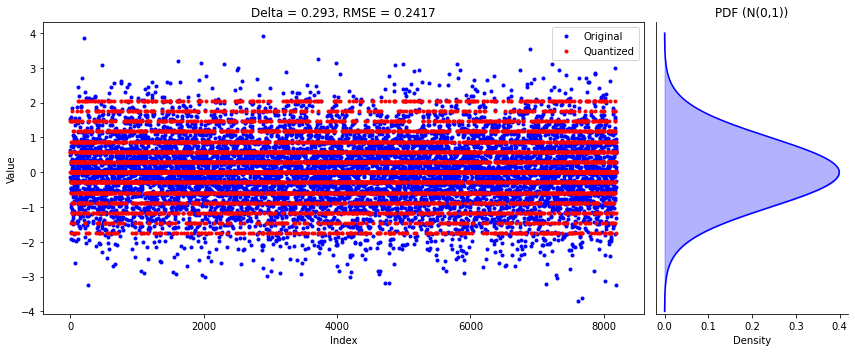

In [3]:
delta = 0.293  # Define delta if not already defined elsewhere
N=1<<13

# Generate data
np.random.seed(42)  # For reproducibility
x = np.random.randn(N)
xq15 = quantize_15(x, delta=delta)

# Create figure with custom layout using GridSpec
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4, figure=fig)

# Main plot on the left (uses 3 out of 4 columns)
ax_main = fig.add_subplot(gs[0, :3])
ax_main.plot(x, "b.", label="Original")
ax_main.plot(xq15, "r.", label="Quantized")
ax_main.set_title(f"Delta = {delta}, RMSE = {rmse(x-xq15):.4f}")
ax_main.legend()
ax_main.set_xlabel("Index")
ax_main.set_ylabel("Value")

# PDF plot on the right (uses 1 out of 4 columns)
ax_pdf = fig.add_subplot(gs[0, 3])

# Generate points for the normal PDF curve
x_pdf = np.linspace(-4, 4, 1000)
y_pdf = stats.norm.pdf(x_pdf, 0, 1)

# Plot the PDF
ax_pdf.plot(y_pdf, x_pdf, color="blue")
ax_pdf.fill_betweenx(x_pdf, 0, y_pdf, color="blue", alpha=0.3)
ax_pdf.set_title("PDF (N(0,1))")
ax_pdf.set_xlabel("Density")
ax_pdf.set_yticks([])  # Hide y-ticks as they're the same as main plot
ax_pdf.spines['top'].set_visible(False)
ax_pdf.spines['right'].set_visible(False)

# Set the y-limits to match the main plot for alignment
ax_pdf.set_ylim(ax_main.get_ylim())

plt.tight_layout()
plt.show()

To find the optimal interval Δ, we follow this method
1. Sample a Gaussian Random Variable to obtain a simulated timestream.
2. Quantize the time-stream to 15 levels for various values of Δ, as shown above.
3. Calculate the root-mean-squared-error (RMSE).
4. Repeat steps 1-3 a M times and average the RMSEs. Then find the best-fit parameters for a parabola going through each of these mean values. Find the argmin of that parabola, which is $-b \over 2a$ for $ax^2 + bx + c$. 
5. Repeat step 4 K times to estimate the optimal Δ precisely. 

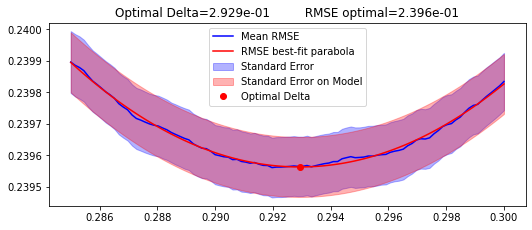

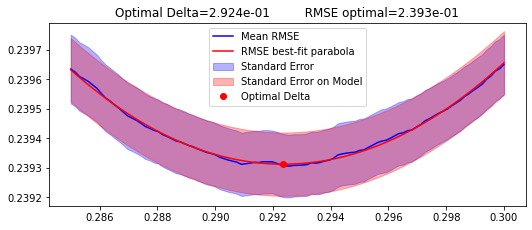

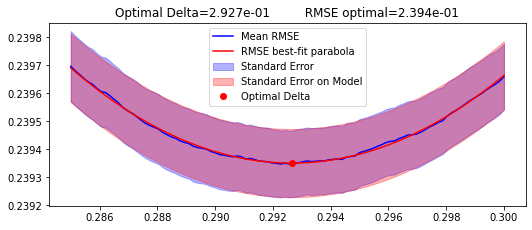

Optimal delta is 2.9265e-01 ± 6.7e-05


In [4]:
N=1<<18
K=1<<3
M=1<<5
np.random.seed(537385)

optimal_deltas=[]
rmse_optimal_deltas=[]

for j in range(K):
    rmses=[]
    for i in range(M):
        rmses.append([])
        x=np.random.randn(N)
        deltas=np.linspace(0.285,0.3,100)
        for delta in deltas:
            rmses[-1].append(rmse(x-quantize_15(x,delta)))

    rmses = np.array(rmses)
    mean_rmses = np.mean(rmses,axis=0)
    std_rmses = np.std(rmses,axis=0)/np.sqrt(rmses.shape[0])

    coeffs_fit = np.polyfit(deltas,mean_rmses,2) # stds are roughly same
    rmses_fit = np.polyval(coeffs_fit, deltas)

    optimal_deltas.append(-coeffs_fit[1]/(2*coeffs_fit[0]))
    rmse_optimal_deltas.append(np.polyval(coeffs_fit, optimal_deltas[-1]))

    if j<3:
        plt.figure(figsize=(7.5,3.3))
        plt.title(f"Optimal Delta={optimal_deltas[-1]:.3e} \
        RMSE optimal={rmse_optimal_deltas[-1]:.3e}")
        # Plot the mean line
        plt.plot(deltas, mean_rmses, 'b-', label='Mean RMSE')
        plt.plot(deltas, rmses_fit, 'r-', label='RMSE best-fit parabola')
        # Add the shaded error region
        plt.fill_between(deltas, 
                         mean_rmses - std_rmses, 
                         mean_rmses + std_rmses, 
                         alpha=0.3, color='b', label='Standard Error')
        plt.fill_between(deltas,
                        rmses_fit - std_rmses.mean(),
                        rmses_fit + std_rmses.mean(),
                         alpha=0.3, color='r', label='Standard Error on Model')
        plt.plot([optimal_deltas[-1]], [rmse_optimal_deltas[-1]], "ro", label="Optimal Delta")
        plt.legend()
        plt.tight_layout()
        plt.show()

optimal_delta = np.mean(optimal_deltas)
optimal_delta_stderr = np.std(optimal_deltas)/np.sqrt(len(optimal_deltas))
print(f"Optimal delta is {optimal_delta:.4e} ± {optimal_delta_stderr:.1e}")

The optimal value of the quantization interval Δ, as a proportion of the normal distribution's 𝜎, is

\\[
0.29265 \pm 6.7\times 10^{-5}.
\\]

### Appendix


In [5]:
print(f"Original STD = {np.std(x):.3f}\nQuantized STD = {np.std(xq15):.3f}\nDelta / resulting STD = {0.293/np.std(xq15):.3f}")

Original STD = 1.001
Quantized STD = 0.860
Delta / resulting STD = 0.341


We should note that quantizing changes the signal's STD slightly because of clipping. For the near-optimal quantization delta of 0.293 in units of the STD, the ratio resulting STD / original STD is about 0.860. Therefore, when verifying whether quantized data is well tuned, one should look for a ratio delta / STD of 0.341.